
# 使用seq2seq实现文本翻译

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 一、前期准备工作

### 1. 搭建语言类

In [2]:
SOS_token = 0
EOS_token = 1

# 语言类，方便对语料库进行操作
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words    = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### 2. 文本处理函数

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 小写化，剔除标点与非字母符号
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

### 3. 文件读取函数

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 以行为单位读取文件
    lines = open('%s-%s.txt'%(lang1,lang2), encoding='utf-8').\
            read().strip().split('\n')

    # 将每一行放入一个列表中
    # 一个列表中有两个元素，A语言文本与B语言文本
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 创建Lang实例，并确认是否反转语言顺序
    if reverse:
        pairs       = [list(reversed(p)) for p in pairs]
        input_lang  = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang  = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

`.startswith(eng_prefixes)` 是字符串方法 `startswith()` 的调用。它用于检查一个字符串是否以指定的前缀开始。

In [8]:
MAX_LENGTH = 10      # 定义语料最长长度

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    # 选取仅仅包含 eng_prefixes 开头的语料
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    # 读取文件中的数据
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    # 按条件选取语料
    pairs = filterPairs(pairs[:])
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    
    # 将语料保存至相应的语言类
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    # 打印语言类的信息    
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['vous etes fort astucieuses .', 'you re very astute .']


## 二、Seq2Seq 模型

### 1. 编码器（Encoder）

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding   = nn.Embedding(input_size, hidden_size)
        self.gru         = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded       = self.embedding(input).view(1, 1, -1)
        output         = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 2. 解码器（Decoder）

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding   = nn.Embedding(output_size, hidden_size)
        self.gru         = nn.GRU(hidden_size, hidden_size)
        self.out         = nn.Linear(hidden_size, output_size)
        self.softmax     = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output         = self.embedding(input).view(1, 1, -1)
        output         = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output         = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 三、训练

### 1. 数据预处理

In [12]:
# 将文本数字化，获取词汇index
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# 将数字化的文本，转化为tensor数据
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# 输入pair文本，输出预处理好的数据
def tensorsFromPair(pair):
    input_tensor  = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 2. 训练函数

In [13]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, 
          encoder, decoder, 
          encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
    
    # 编码器初始化
    encoder_hidden = encoder.initHidden()
    
    # grad属性归零
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length  = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # 用于创建一个指定大小的全零张量（tensor），用作默认编码器输出
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    # 将处理好的语料送入编码器
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei]            = encoder_output[0, 0]
    
    # 解码器默认输出
    decoder_input  = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # 将编码器处理好的输出送入解码器
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            loss         += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            topv, topi    = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss         += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

在序列生成的任务中，如机器翻译或文本生成，解码器（decoder）的输入通常是由解码器自己生成的预测结果，即前一个时间步的输出。然而，这种自回归方式可能存在一个问题，即在训练过程中，解码器可能会产生累积误差，并导致输出与目标序列逐渐偏离。

为了解决这个问题，引入了一种称为"Teacher Forcing"的技术。在训练过程中，Teacher Forcing将目标序列的真实值作为解码器的输入，而不是使用解码器自己的预测结果。这样可以提供更准确的指导信号，帮助解码器更快地学习到正确的输出。

在这段代码中，`use_teacher_forcing`变量用于确定解码器在训练阶段使用何种策略作为下一个输入。

当`use_teacher_forcing`为`True`时，采用"Teacher Forcing"的策略，即将目标序列中的真实标签作为解码器的下一个输入。而当`use_teacher_forcing`为`False`时，采用"Without Teacher Forcing"的策略，即将解码器自身的预测作为下一个输入。

使用`use_teacher_forcing`的目的是在训练过程中平衡解码器的预测能力和稳定性。以下是对两种策略的解释：

1.  Teacher Forcing: 在每个时间步（`di`循环中），解码器的输入都是目标序列中的真实标签。这样做的好处是，解码器可以直接获得正确的输入信息，加快训练速度，并且在训练早期提供更准确的梯度信号，帮助解码器更好地学习。然而，过度依赖目标序列可能会导致模型过于敏感，一旦目标序列中出现错误，可能会在解码器中产生累积的误差。
    
2.  Without Teacher Forcing: 在每个时间步，解码器的输入是前一个时间步的预测输出。这样做的好处是，解码器需要依靠自身的预测能力来生成下一个输入，从而更好地适应真实应用场景中可能出现的输入变化。这种策略可以提高模型的稳定性，但可能会导致训练过程更加困难，特别是在初始阶段。
    

一般来说，Teacher Forcing策略在训练过程中可以帮助模型快速收敛，而Without Teacher Forcing策略则更接近真实应用中的生成场景。通常会使用一定比例的Teacher Forcing，在训练过程中逐渐减小这个比例，以便模型逐渐过渡到更自主的生成模式。

综上所述，通过使用`use_teacher_forcing`来选择不同的策略，可以在训练解码器时平衡模型的预测能力和稳定性，同时也提供了更灵活的生成模式选择。

1.  `topv, topi = decoder_output.topk(1)`
    
    这一行代码使用`.topk(1)`函数从`decoder_output`中获取最大的元素及其对应的索引。`decoder_output`是一个张量（tensor），它包含了解码器的输出结果，可能是一个概率分布或是其他的数值。`.topk(1)`函数将返回两个张量：`topv`和`topi`。`topv`是最大的元素值，而`topi`是对应的索引值。
    
2.  `decoder_input = topi.squeeze().detach()`

    这一行代码对`topi`进行处理，以便作为下一个解码器的输入。首先，`.squeeze()`函数被调用，它的作用是去除张量中维度为1的维度，从而将`topi`的形状进行压缩。然后，`.detach()`函数被调用，它的作用是将张量从计算图中分离出来，使得在后续的计算中不会对该张量进行梯度计算。最后，将处理后的张量赋值给`decoder_input`，作为下一个解码器的输入。

In [14]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder,decoder,n_iters,print_every=1000,
               plot_every=100,learning_rate=0.01):
    
    start = time.time()
    plot_losses      = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total  = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # 在 pairs 中随机选取 n_iters 条数据用作训练集
    training_pairs    = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion         = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor  = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total  += loss

        if iter % print_every == 0:
            print_loss_avg   = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

## 四、训练与评估

In [16]:
hidden_size   = 256
encoder1      = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses = trainIters(encoder1, attn_decoder1, 20000, print_every=5000)

1m 1s (- 3m 4s) (5000 25%) 2.9028
2m 1s (- 2m 1s) (10000 50%) 2.3680
3m 4s (- 1m 1s) (15000 75%) 2.0560
4m 6s (- 0m 0s) (20000 100%) 1.8216


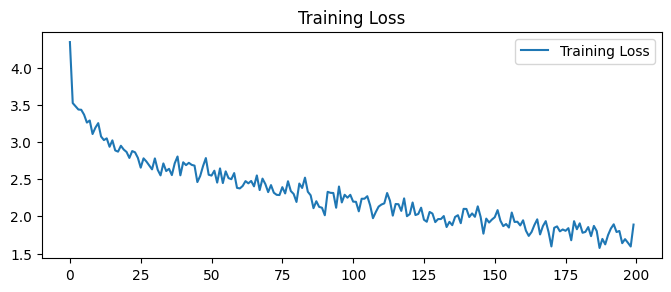

In [17]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               # 忽略警告信息
# plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        # 分辨率

epochs_range = range(len(plot_losses))

plt.figure(figsize=(8, 3))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, plot_losses, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()